# Lab 1

Group Members:

- Parker

- Suma 

- Chris

- Oliver

## Introduction

**Why is it important to find this kind of bias in machine learning models?**

TODO: Answer this

**Why will the type of investigation I am performing be relevant to other researchers or practitioners?**

TODO: Answer this

For example, we are trying to answer if a romantic comedy is ranked as more positive or if a horror movie is ranked as more negative. 

To do this, we utilize the dataset of IMDB reviews that are pre-labeled as positive or negative and contain movie genres.
We will analyze the bias using the word embeddings of GloVe & ConceptNet. Each of these embeddings will be applied to the movie reviews to determine the overall sentiment of the review. 

We believe that a "lesser" embedding will perform more poorly in the face of a conflicting sentiment lexicon. By this, we expect that "horror" movies may have more "negative" ratings because of the "negative" words used in the reviews to describe the content of the movie, versus the overall context of the review as positive or negative. If the embedding is more narrow-focused, like Glove, it may produce results that bias towards romantic comedies as more positive, since the overall content of the review should have more "positive" words based on the content of the movie. However, we expect an embedding that has a wider knowledge graph focus, like ConceptNet, to remove this bias and focus solely on the review content.

## Investigation

Dataset has 1 million reviews from 1150 movies spread across 17 genres; there's also other meta data such as the IMDb rating and movie rating. 

Source: https://ieee-dataport.org/open-access/imdb-movie-reviews-dataset

Reference Paper: https://ieeexplore-ieee-org.proxy.libraries.smu.edu/document/9276893 

### Embeddings

We will be making our bias comparisons using the GLoVe and ConceptNet Numberbatch word embeddings. As iterated before, we believe that because of Numberbatch's broader generalization, we can prove that there exists a bias using GLoVe in which a romantic comedy movie, for example, may be rated as positive based on the inherent content of the review even though it received a negative numeric rating.

### Comparison metric

F-score

TODO: Explain why

### Hypothesis

TODO: Write hypothesis

## Training / Modelling

### Loading Embeddings and Lexicons

In [10]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
#this code is taken from LectureNotesMaster/01 ConceptNet.ipynb notebook shared by Prof E Larson/Robyn Speer

def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('data/glove.840B.300d.txt')
embeddings.shape

(2196018, 300)

In [4]:
#Loading the lexicon
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

print(len(pos_words), len(neg_words))

2006 4783


### Preparing Sentiment Classifier

In [5]:
#train the model
pos_words_common = list(set(pos_words) & set(embeddings.index)) 
neg_words_common = list(set(neg_words) & set(embeddings.index)) 

pos_vectors = embeddings.loc[pos_words_common]
neg_vectors = embeddings.loc[neg_words_common]
print(pos_vectors.shape,neg_vectors.shape)

(1974, 300) (4642, 300)


In [6]:
#train the inputs and outputs
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [7]:
#prep for train test split
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [9]:
# create a linear classifier 
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)
accuracy_score(model.predict(test_vectors), test_targets)



0.9546827794561934

### Sentiment Analysis Functions

In [10]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier, 
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    # Filter the list of words to only include those present in the embeddings
    filtered_words = [word for word in words if word in embeddings.index]
    
    # If no words are found in the embeddings, return an empty DataFrame or some default sentiment value
    if not filtered_words:
        return pd.DataFrame({'sentiment': []})
    
    vecs = embeddings.loc[filtered_words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)



# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

,sentiment
miserably,-8.467720
remission,5.897825
awfully,-6.856798
scared,-12.798662
sensationally,6.440469
momentous,4.026076
pride,3.956458
subpoena,-6.236719
anti-white,-6.282487
severity,-11.472931


In [11]:
#tokenize using regular expressions

TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    # Tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    # Filter tokens to include only those that are in the embeddings' index
    tokens = [token for token in tokens if token in embeddings.index]
    
    # If no tokens are found in the embeddings, return a default sentiment value, e.g., 0
    if not tokens:
        return 0  # This is a neutral sentiment score
    
    sentiments = words_to_sentiment(tokens)
    if sentiments.empty:
        return 0  # Again, returning a neutral sentiment score if no sentiments were computed
    return sentiments['sentiment'].mean()  # Return the mean sentiment for the remaining tokens


### Loading Movie Data

In [21]:
#Load the movie list for Comedy
import pandas as pd
df_cat1_movies = pd.read_csv('data/movie_dataset/1_movies_per_genre/Comedy.csv', sep = ',')
df_cat1_movies.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url
0,Guardians of the Galaxy,2014,PG-13,2h 1min,Comedy;,1 August 2014 (USA),8.0,1017578,1390,https://www.imdb.com/title/tt2015381/reviews/_...
1,Back to the Future,1985,PG,1h 56min,Comedy;,3 July 1985 (USA),8.5,1015437,1178,https://www.imdb.com/title/tt0088763/reviews/_...
2,Finding Nemo,2003,G,1h 40min,Comedy;,30 May 2003 (USA),8.1,922237,968,https://www.imdb.com/title/tt0266543/reviews/_...
3,Up,2009,PG,1h 36min,Comedy;,29 May 2009 (USA),8.2,905205,891,https://www.imdb.com/title/tt1049413/reviews/_...
4,The Truman Show,1998,PG,1h 43min,Comedy;,5 June 1998 (USA),8.1,901368,1152,https://www.imdb.com/title/tt0120382/reviews/_...


In [22]:
df_cat2_movies = pd.read_csv('data/movie_dataset/1_movies_per_genre/Horror.csv', sep = ',')
df_cat2_movies.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url
0,The Shining,1980,R,2h 26min,Drama; Horror;,13 June 1980 (USA),8.4,860290,1805,https://www.imdb.com/title/tt0081505/reviews/_...
1,Alien,1979,R,1h 57min,Horror; Sci-Fi;,22 June 1979 (USA),8.4,762793,1423,https://www.imdb.com/title/tt0078748/reviews/_...
2,World War Z,2013,PG-13,1h 56min,Action; Adventure; Horror;,21 June 2013 (USA),7.0,586801,1125,https://www.imdb.com/title/tt0816711/reviews/_...
3,Psycho,1960,R,1h 49min,Horror; Mystery; Thriller;,8 September 1960 (USA),8.5,580951,1263,https://www.imdb.com/title/tt0054215/reviews/_...
4,Shaun of the Dead,2004,R,1h 39min,Comedy; Horror;,24 September 2004 (USA),7.9,499244,971,https://www.imdb.com/title/tt0365748/reviews/_...


In [23]:
#I feel name, year and genres cols in the csv files are sufficient to retain, drop the rest, add cols back in as needed
df_cat1_movies_lim=df_cat1_movies[['name', 'year',  'genres']]
df_cat2_movies_lim=df_cat2_movies[['name', 'year', 'genres']]

Interesting  problem - there is movie titled Evil Dead thats a Comedy;Horror mix. May be we need load Cat1 to some other genre?

For the movies in the dataframes we have loaded, bring in the reviews

In [24]:
df_concat_movies = pd.concat([df_cat1_movies_lim, df_cat2_movies_lim])
df_concat_movies['file_name'] = df_concat_movies['name'] + ' ' + df_concat_movies['year'].astype(str) + '.csv'

df_concat_movies.head()

,name,year,genres,file_name
0,Guardians of the Galaxy,2014,Comedy;,Guardians of the Galaxy 2014.csv
1,Back to the Future,1985,Comedy;,Back to the Future 1985.csv
2,Finding Nemo,2003,Comedy;,Finding Nemo 2003.csv
3,Up,2009,Comedy;,Up 2009.csv
4,The Truman Show,1998,Comedy;,The Truman Show 1998.csv


### Combining Movie Reviews

In [25]:
#https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
# and https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
import os
directory = 'data/movie_dataset/2_reviews_per_movie_raw'

dfs = list()

# iterate over files in
# that directory
for filename in os.listdir(directory):	
	#print('looking for :', filename) 
	if df_concat_movies['file_name'].eq(filename).any():		
		data = pd.read_csv(os.path.join(directory, filename), header=None)
		data['file_name'] = filename
#		data['genre'] = df_concat_movies['genres']        
		dfs.append(data)
df = pd.concat(dfs, ignore_index=True)

Continuing with some data cleanup

In [17]:
df = pd.DataFrame(df)
df = df.rename(columns={"filename": "file_name"})
df_all = df_concat_movies.merge(df)
df_all.columns = df_all.iloc[0]
df_all = df_all[1:]
df_all = df_all.reset_index(drop=True)
# Fixing a weird result from the merge - this seems to work ok
df_all = df_all.rename(columns={"Guardians of the Galaxy": "film name", 2014: "year", 'Comedy; ': "genre", "Guardians of the Galaxy 2014.csv": "file_name"})
df_all = df_all.drop(columns=['file_name','username', 'helpful', 'total', 'date','title'])
df_all['genre'] = df_all['genre'].str.replace(';','',regex=True)
df_all.head()

,film name,year,genre,rating,review
0,Guardians of the Galaxy,2014,Comedy,10,Guardians of the Galaxy is nothing short of an...
1,Guardians of the Galaxy,2014,Comedy,9,I originally saw in the theater which was grea...
2,Guardians of the Galaxy,2014,Comedy,9,I remember sitting in Hall H at Comic-Con two ...
3,Guardians of the Galaxy,2014,Comedy,9,Expectations: surpassed - and they were pretty...
4,Guardians of the Galaxy,2014,Comedy,10,I entitle my review A New Hope as I walk out o...


In [18]:
df_all.to_csv('df_all.csv', index=False)

In [19]:
df_all.head()

,film name,year,genre,rating,review
0,Guardians of the Galaxy,2014,Comedy,10,Guardians of the Galaxy is nothing short of an...
1,Guardians of the Galaxy,2014,Comedy,9,I originally saw in the theater which was grea...
2,Guardians of the Galaxy,2014,Comedy,9,I remember sitting in Hall H at Comic-Con two ...
3,Guardians of the Galaxy,2014,Comedy,9,Expectations: surpassed - and they were pretty...
4,Guardians of the Galaxy,2014,Comedy,10,I entitle my review A New Hope as I walk out o...


In [20]:
# Filter for 'Comedy' genre only (excluding rows that also contain 'Horror')
df_romcom = df_all[df_all['genre'].str.contains('Comedy') & ~df_all['genre'].str.contains('Horror')]

# Filter for 'Horror' genre only (excluding rows that also contain 'Comedy')
df_horror = df_all[df_all['genre'].str.contains('Horror') & ~df_all['genre'].str.contains('Comedy')]

In [21]:
df_romcom.head()

,film name,year,genre,rating,review
0,Guardians of the Galaxy,2014,Comedy,10,Guardians of the Galaxy is nothing short of an...
1,Guardians of the Galaxy,2014,Comedy,9,I originally saw in the theater which was grea...
2,Guardians of the Galaxy,2014,Comedy,9,I remember sitting in Hall H at Comic-Con two ...
3,Guardians of the Galaxy,2014,Comedy,9,Expectations: surpassed - and they were pretty...
4,Guardians of the Galaxy,2014,Comedy,10,I entitle my review A New Hope as I walk out o...


In [22]:
df_horror.head()

,film name,year,genre,rating,review
78795,The Shining,1980,Drama Horror,rating,review
78796,The Shining,1980,Drama Horror,Null,"When this film first came out in 1980, I remem..."
78797,The Shining,1980,Drama Horror,Null,I can't praise this film long enough!<br/><br/...
78798,The Shining,1980,Drama Horror,Null,Stephen King may have said the master director...
78799,The Shining,1980,Drama Horror,9,Even though The Shining is over a quarter of a...


We have 174941 rows of movie reviews, with 5 columns of information: 
- Film Name
- Year
- Genre
- Rating
- Review


In [23]:
#TODO: We need to add the header in to the appended reviews file.

In [26]:

# Apply the text_to_sentiment function to each review in the df_romcom DataFrame
df_romcom['sentiment'] = df_romcom['review'].apply(text_to_sentiment)

# Calculate the average sentiment for comedies
average_sentiment_comedy = df_romcom['sentiment'].mean()

# Apply the text_to_sentiment function to each review in the df_horror DataFrame
df_horror['sentiment'] = df_horror['review'].apply(text_to_sentiment)

# Calculate the average sentiment for horror movies
average_sentiment_horror = df_horror['sentiment'].mean()

# Print the average sentiments
print(f"Average Sentiment for Comedies: {average_sentiment_comedy}")
print(f"Average Sentiment for Horror Movies: {average_sentiment_horror}")

In [25]:
#Average Sentiment for Comedies: 0.36794964103811045
average_sentiment_comedy = 0.36794964103811045
#Average Sentiment for Horror Movies: -0.15294894375162382
average_sentiment_horror = -0.15294894375162382

In [3]:
df_romcom_glove_trim = pd.read_csv("df_romcom_glove_trim.csv").drop(columns=["year", "genre"]).dropna()
df_horror_glove_trim = pd.read_csv("df_horror_glove_trim.csv").drop(columns=["year", "genre"]).dropna()
df_romcom_glove_trim.head()

,film name,rating,sentiment
0,Guardians of the Galaxy,10,0.787825
1,Guardians of the Galaxy,9,2.014900
2,Guardians of the Galaxy,9,0.716487
3,Guardians of the Galaxy,9,1.347274
4,Guardians of the Galaxy,10,1.005797


C:\Users\chris\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


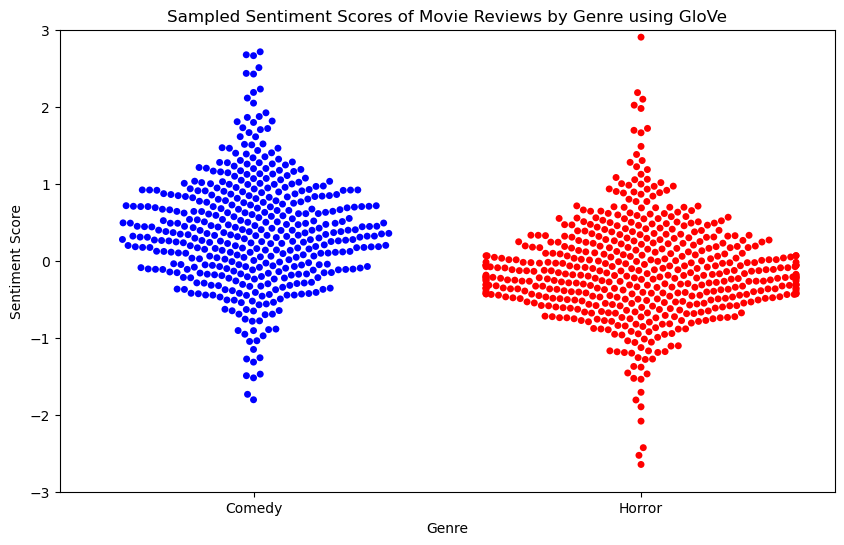

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_glove_trim['genre'] = 'Comedy'
df_horror_glove_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_glove_trim[['sentiment', 'genre']], df_horror_glove_trim[['sentiment', 'genre']]])

# Sample a subset of the data for plotting
df_sampled = df_combined.sample(n=1000, random_state=1)  # Adjust n as needed

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.swarmplot(x='genre', y='sentiment', data=df_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using GloVe')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3, 3) 

plt.show()

Based on the sample, comedy sentiment score  mean appears to be overall a bit higher than horror. But this may vary based on the sample. The swarm plot indicates the data for comedy has more values greater than 0 and more positive outlier values for comedy. Where as the negative tail of horror indicates there may be some reviews that had very high negative values. Overall the number of negative sentiments around or below 0 for horror seem to outweigh the positive sentiments.

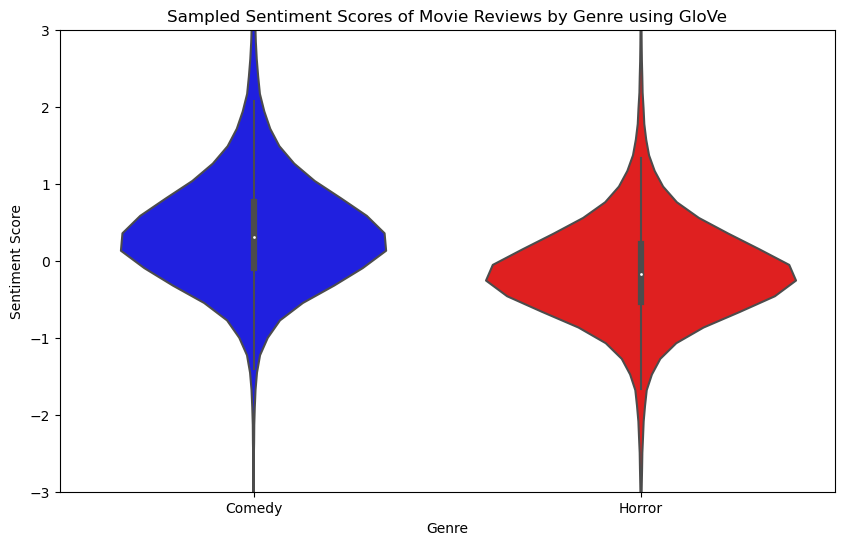

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_glove_trim['genre'] = 'Comedy'
df_horror_glove_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_glove_trim[['sentiment', 'genre']], df_horror_glove_trim[['sentiment', 'genre']]])

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.violinplot(x='genre', y='sentiment', data=df_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using GloVe')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3, 3) 
plt.show()

The violin plot also indicates the mean vaue to be just above 0 for comedy and less tha 0 for horror. The breadth of the data around the mean for horror shows there are greater instances of sentiment scores hovering around the mean.

## Perform Similar Analysis with ConceptNet


In [ ]:
embeddings = load_embeddings('data/numberbatch-en-17.04b.txt')
embeddings.shape

#train the model
pos_words_common = list(set(pos_words) & set(embeddings.index)) 
neg_words_common = list(set(neg_words) & set(embeddings.index)) 

pos_vectors = embeddings.loc[pos_words_common]
neg_vectors = embeddings.loc[neg_words_common]
print(pos_vectors.shape,neg_vectors.shape)

#train the inputs and outputs
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

#prep for train test split
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

# create a linear classifier 
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)
accuracy_score(model.predict(test_vectors), test_targets)

# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

#tokenize using regular expressions

TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


In [ ]:
# Apply the text_to_sentiment function to each review in the df_romcom DataFrame
df_romcom['sentiment'] = df_romcom['review'].apply(text_to_sentiment)

# Calculate the average sentiment for comedies
average_sentiment_comedy = df_romcom['sentiment'].mean()

# Apply the text_to_sentiment function to each review in the df_horror DataFrame
df_horror['sentiment'] = df_horror['review'].apply(text_to_sentiment)

# Calculate the average sentiment for horror movies
average_sentiment_horror = df_horror['sentiment'].mean()

# Print the average sentiments
print(f"Average Sentiment for Comedies: {average_sentiment_comedy}")
print(f"Average Sentiment for Horror Movies: {average_sentiment_horror}")

- Average Sentiment for Comedies: 0.029119482163650175
- Average Sentiment for Horror Movies: -0.20205652231804702

In [ ]:
df_romcom.to_csv('df_romcom_cnnb.csv', index=False)
df_horror.to_csv('df_horror_cnnb.csv', index=False)
df_romcom_cnnb_trim = df_romcom.drop(columns=['review'])
df_horror_cnnb_trim = df_horror.drop(columns=['review'])
df_romcom_cnnb_trim.to_csv('df_romcom_cnnb_trim.csv', index=False)
df_horror_cnnb_trim.to_csv('df_horror_cnnb_trim.csv', index=False)

C:\Users\chris\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


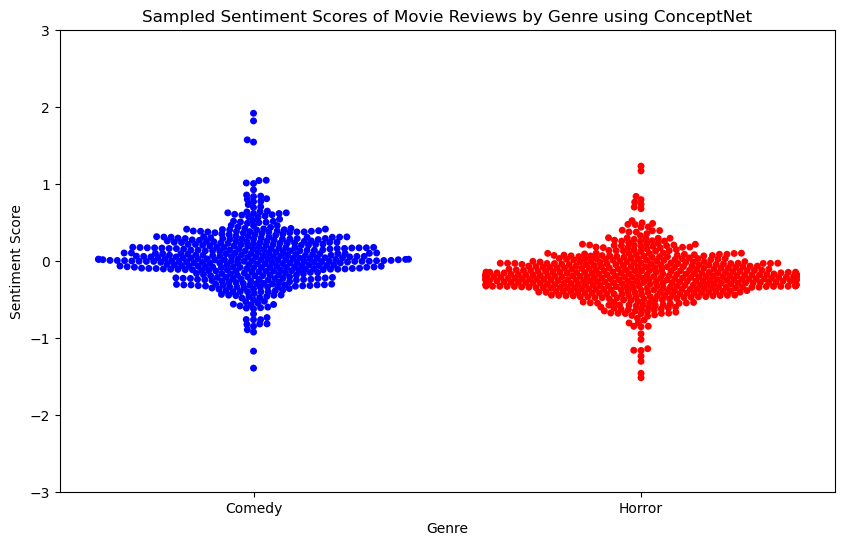

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_cnnb_trim['genre'] = 'Comedy'
df_horror_cnnb_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_cnnb_trim[['sentiment', 'genre']], df_horror_cnnb_trim[['sentiment', 'genre']]])

# Sample a subset of the data for plotting
df_sampled = df_combined.sample(n=1000, random_state=1)  # Adjust n as needed

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.swarmplot(x='genre', y='sentiment', data=df_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using ConceptNet')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3,3) 

plt.show()

ConceptNet data shows a lot of overlap between Comedy and GloVe embeddings. The mean of both appear to be very close to 0. The outliers of horror in is not as widespread as it is for Comedy indicating some much higher positive sentiment scores for comedy than horror as was expected. Overall the majority of the scores hover around 0 which I believe must indicate neutral sentiment.

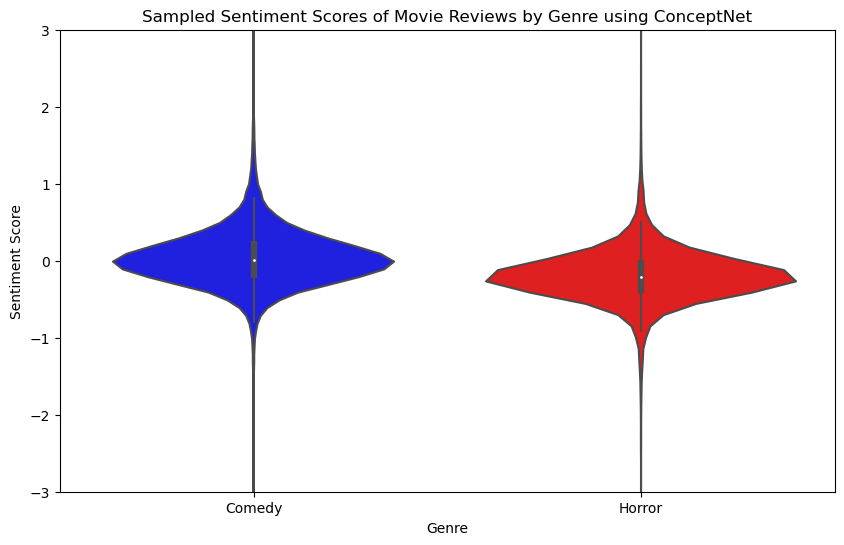

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_cnnb_trim['genre'] = 'Comedy'
df_horror_cnnb_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_cnnb_trim[['sentiment', 'genre']], df_horror_cnnb_trim[['sentiment', 'genre']]])

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.violinplot(x='genre', y='sentiment', data=df_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using ConceptNet')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3,3) 

plt.show()

The violin plot visually confirms the means of both genres are much closer in ConceptNet than GloVe.

## Analysis
Now that the reviews have been given a sentiment score using Glove and ConceptNet, we begin the analysis. We will use the F-test which is a statistical test used to compare the variances of two or more samples or populations in hypothesis testing to determine whether they are significantly different or not. 

The null hypothesis is that there is NO difference in the variance of the two genres. The alternate hypothesis therefore is that there is a significant variance between the two groups based on the sentiment score.

We will run the f-test before we normalize the data and also after, just for affirmation.

The f-test will look at comparing the f-stat with the f-critical value to determine whether to accept or reject the null hypothesis. Alternatively we can use the p-value, compared with the significance level and accept or reject the hypothesis. Lets go!

In [1]:
import pandas as pd
import warnings 

warnings.filterwarnings('ignore')
#Load GloVe Horror Results
df_horror_glove_trim = pd.read_csv('df_horror_glove_trim.csv', sep = ',')
df_horror_glove_trim.head()

C:\Users\schack\AppData\Local\Temp\ipykernel_1560\3650679571.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,film name,year,genre,rating,sentiment
0,The Shining,1980,Drama Horror,rating,-0.981984
1,The Shining,1980,Drama Horror,Null,0.221749
2,The Shining,1980,Drama Horror,Null,0.520957
3,The Shining,1980,Drama Horror,Null,0.365487
4,The Shining,1980,Drama Horror,9,-0.084957


In [2]:
#Load GloVe RomCom Results
df_romcom_glove_trim = pd.read_csv('df_romcom_glove_trim.csv', sep = ',')
df_romcom_glove_trim.head()

,film name,year,genre,rating,sentiment
0,Guardians of the Galaxy,2014,Comedy,10,0.787825
1,Guardians of the Galaxy,2014,Comedy,9,2.014900
2,Guardians of the Galaxy,2014,Comedy,9,0.716487
3,Guardians of the Galaxy,2014,Comedy,9,1.347274
4,Guardians of the Galaxy,2014,Comedy,10,1.005797


In [3]:
#Load ConceptNet NumberBatch Horror Results
df_horror_cnnb_trim = pd.read_csv('df_horror_cnnb_trim.csv', sep = ',')
df_horror_cnnb_trim.head()

,film name,year,genre,rating,sentiment
0,The Shining,1980,Drama Horror,rating,0.905336
1,The Shining,1980,Drama Horror,Null,-0.048046
2,The Shining,1980,Drama Horror,Null,0.077248
3,The Shining,1980,Drama Horror,Null,-0.108780
4,The Shining,1980,Drama Horror,9,-0.291112


In [4]:
#Load ConceptNet NumberBatch RomCom Results
df_romcom_cnnb_trim = pd.read_csv('df_romcom_cnnb_trim.csv', sep = ',')
df_romcom_cnnb_trim.head()

,film name,year,genre,rating,sentiment
0,Guardians of the Galaxy,2014,Comedy,10,0.235207
1,Guardians of the Galaxy,2014,Comedy,9,0.975840
2,Guardians of the Galaxy,2014,Comedy,9,0.134740
3,Guardians of the Galaxy,2014,Comedy,9,0.293742
4,Guardians of the Galaxy,2014,Comedy,10,0.283084


In [5]:
#this data prep needs to be done as genre is being used for grouping
df_romcom_glove_trim['genre'] = 'Comedy'
df_horror_glove_trim['genre'] = 'Horror'

df_romcom_cnnb_trim['genre'] = 'Comedy'
df_horror_cnnb_trim['genre'] = 'Horror'

#data preparation for rating
# Try to convert each row's rating column to a float, removing any rows that can't be converted
df_horror_glove_trim['rating'] = pd.to_numeric(df_horror_glove_trim['rating'], errors='coerce')
df_horror_glove_trim = df_horror_glove_trim.dropna(subset=['rating'])

df_romcom_glove_trim['rating'] = pd.to_numeric(df_romcom_glove_trim['rating'], errors='coerce')
df_romcom_glove_trim = df_romcom_glove_trim.dropna(subset=['rating'])

df_horror_cnnb_trim['rating'] = pd.to_numeric(df_horror_cnnb_trim['rating'], errors='coerce')
df_horror_cnnb_trim = df_horror_cnnb_trim.dropna(subset=['rating'])

df_romcom_cnnb_trim['rating'] = pd.to_numeric(df_romcom_cnnb_trim['rating'], errors='coerce')
df_romcom_cnnb_trim = df_romcom_cnnb_trim.dropna(subset=['rating'])


df_combined_glove = pd.concat([df_horror_glove_trim[['rating', 'sentiment', 'genre']], \
                                    df_romcom_glove_trim[['rating', 'sentiment', 'genre']]])
df_combined_cnnb = pd.concat([df_horror_cnnb_trim[['rating', 'sentiment', 'genre']], \
                                    df_romcom_cnnb_trim[['rating', 'sentiment', 'genre']]])



#### Get some stats before Normalization


The null hypothesis is that there is no variance between the two genres. The alternate hypothesis is H1, that they are different. The sentiment analysis is biased based on the genre. 


The following is a function that accepts a pandas dataframe, the embedding name, the sentiment score is the value of the independent factor which is genre for this dataset.

In [6]:
#F-stat, some part of this code was from https://www.geeksforgeeks.org/how-to-find-the-f-critical-value-in-python/
import scipy.stats as stats
import math
def calc_stats(this_df, desc_name, value_column, groupby='genre'):
    
    unique_values_set = this_df[groupby].unique()
    #I could use a for loop but i know only 2 uniques should come in
    fstat,pval = stats.f_oneway(
        this_df[value_column][this_df[groupby] == unique_values_set[0]],
        this_df[value_column][this_df[groupby] == unique_values_set[1]],        
        )
    print()
    print('For ', desc_name)
    print('-'*20)
    
    number_of_groups = 2 #comedy and horror
    numerator_degfreedom = -number_of_groups - 1
    denominator_degfreedom = len(this_df.index)-number_of_groups #numb of observations - number of groups
    alpha = 0.05 #significance level and since we are doing one tailed we dont divide this by 2

    fcritical = stats.f.ppf(q=0.05, dfn=numerator_degfreedom , dfd=denominator_degfreedom)
    
    print('F-statistic: ',fstat,' , p value:', pval, ', alpha:', alpha, ', f-critical:', fcritical )

    print('Analysis on ', value_column, ' results based on F-stat:')
    if math.isnan(fstat):
        print('  fstat cannot be used for comparision as it is nan')
    if math.isnan(fcritical):
        print('  fcritical cannot be used for comparision as it is nan')
    else:
        if fstat > fcritical:
            print('  F-stat is greater than f-critical : Reject the null hypothesis')
        else:
            print('  F-stat is less than f-critical : Fail to reject the null hypothesis')
    if math.isnan(pval):
        print('  p value cannot be used for comparision as it is nan')
    if pval < alpha:
        print('  p value is less than alpha : Reject the null hypothesis')
    else:
        print('  p value is greater than alpha : Fail to reject the null hypothesis')





In [7]:
calc_stats(df_combined_glove,'GloVe', 'sentiment', 'genre')
calc_stats(df_combined_cnnb,'ConceptNet', 'sentiment', 'genre')


For  GloVe
--------------------
F-statistic:  18774.30642197589  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
  p value is less than alpha : Reject the null hypothesis

For  ConceptNet
--------------------
F-statistic:  15755.665718197146  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
  p value is less than alpha : Reject the null hypothesis


Based on the statistical analysis above, the null hypothesis must be rejected. We chose 0.05 which is a typical alpha level. 

### Normalize sentiment between 0-1

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply the MinMaxScaler to the sentiment column of each DataFrame
df_combined_glove['sentiment'] = scaler.fit_transform(df_combined_glove[['sentiment']])
df_combined_cnnb['sentiment'] = scaler.fit_transform(df_combined_cnnb[['sentiment']])


# Print average sentiment for each genre
print('GloVe Sentiment Mean:', df_combined_glove['sentiment'].mean())
print('-'*40)
print('ConceptNet Sentiment Mean:', df_combined_cnnb['sentiment'].mean())


GloVe Sentiment Mean: 0.45494311755575656
----------------------------------------
ConceptNet Sentiment Mean: 0.45611787806422144


### Normalize rating between 0-1

In [9]:
# Normalize the rating column for each combined DataFrame
df_combined_glove['rating'] = scaler.fit_transform(df_combined_glove[['rating']])
df_combined_cnnb['rating'] = scaler.fit_transform(df_combined_cnnb[['rating']])

# Print the average rating for each
print('GloVe Rating Mean:', df_combined_glove['rating'].mean())
print('-'*40)
print('ConceptNet Rating Mean:', df_combined_cnnb['rating'].mean())

GloVe Rating Mean: 0.6517294466032543
----------------------------------------
ConceptNet Rating Mean: 0.6517294466032543


### Adding delta column

In [10]:
# Add a new column to each DataFrame to find the delta between sentiment and rating
df_combined_glove['delta'] = df_combined_glove['sentiment'] - df_combined_glove['rating']
df_combined_cnnb['delta'] = df_combined_cnnb['sentiment'] - df_combined_cnnb['rating']

# Print the average delta for each genre
print('GloVe Delta Mean:', df_combined_glove['delta'].mean())
print('-'*40)
print('ConceptNet Delta Mean:', df_combined_cnnb['delta'].mean())


GloVe Delta Mean: -0.19678632904749774
----------------------------------------
ConceptNet Delta Mean: -0.1956115685390329


As is evident from the mean, the sentiment score is given a lower value based on the words in the review than the rating that the reviewer gave it. 

### Prepare data for plotting 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample a subset of the ConceptNet data for plotting
df_cnnb_sampled = df_combined_cnnb.sample(n=1000, random_state=1)  # Adjust n as needed

# Sample a subset of the GloVe data for plotting
df_glove_sampled = df_combined_glove.sample(n=1000, random_state=1)  # Adjust n as needed

## Plot Normalized Sentiments and Ratings

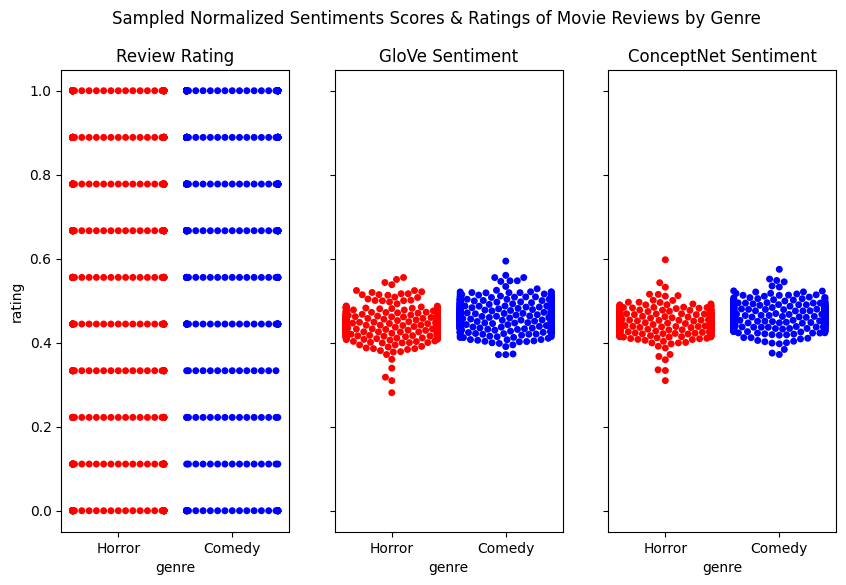

In [12]:
#Create a Swarm plot
fig, axes = plt.subplots(1, 3, figsize=(10,6), sharey=True)
fig.suptitle('Sampled Normalized Sentiments Scores & Ratings of Movie Reviews by Genre')

# Plot the sampled CNNB data for rating
sns.swarmplot(ax=axes[0], x='genre', y='rating', data=df_cnnb_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[0].set_title('Review Rating')

# Plot the sampled Glove data for sentiment
sns.swarmplot(ax=axes[1], x='genre', y='sentiment', data=df_glove_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[1].set_title('GloVe Sentiment')

## ConceptNet
# Plot the sampled ConcepNet data for sentiment
sns.swarmplot(ax=axes[2], x='genre', y='sentiment', data=df_cnnb_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[2].set_title('ConceptNet Sentiment')

plt.show()

The normalized data in GloVe and ConceptNet the edge comedy has over horror. The horrow data sampled indicates that there are lower negative values associated with horror for both embeddings. 

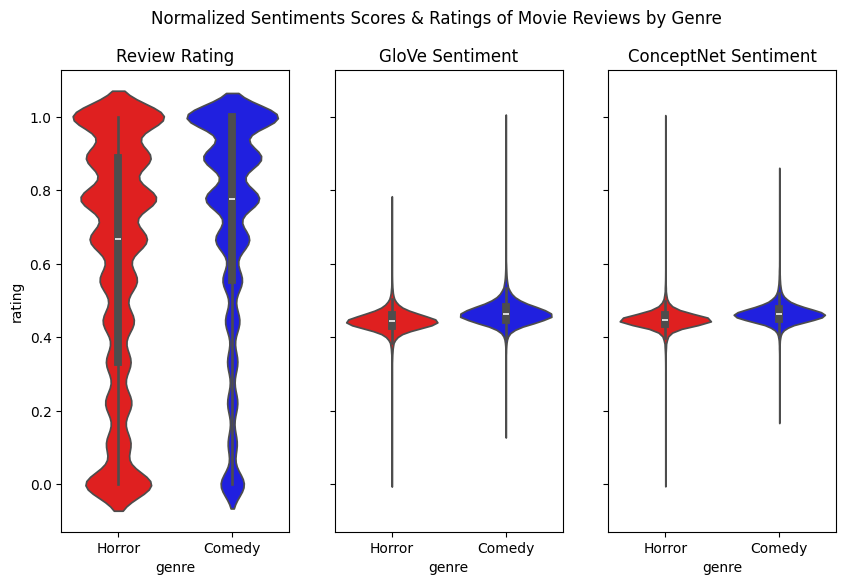

In [13]:
## Doing the same but with Violin Plots and against the entire dataset not just sampled

fig, axes = plt.subplots(1, 3, figsize=(10,6), sharey=True)
fig.suptitle('Normalized Sentiments Scores & Ratings of Movie Reviews by Genre')

## Review Rating
# Plot the data

sns.violinplot(ax=axes[0], x='genre', y='rating', data=df_combined_cnnb, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[0].set_title('Review Rating')

## GloVe
# Plot the data
sns.violinplot(ax=axes[1], x='genre', y='sentiment', data=df_combined_glove, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[1].set_title('GloVe Sentiment')

## ConceptNet
# Plot the data
sns.violinplot(ax=axes[2], x='genre', y='sentiment', data=df_combined_cnnb, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[2].set_title('ConceptNet Sentiment')

plt.show()

An alternate to the above view: 
#TODO Feel free to replace. I want to show how there is a spread of the data for rating whereas sentiment is all hovering around the median


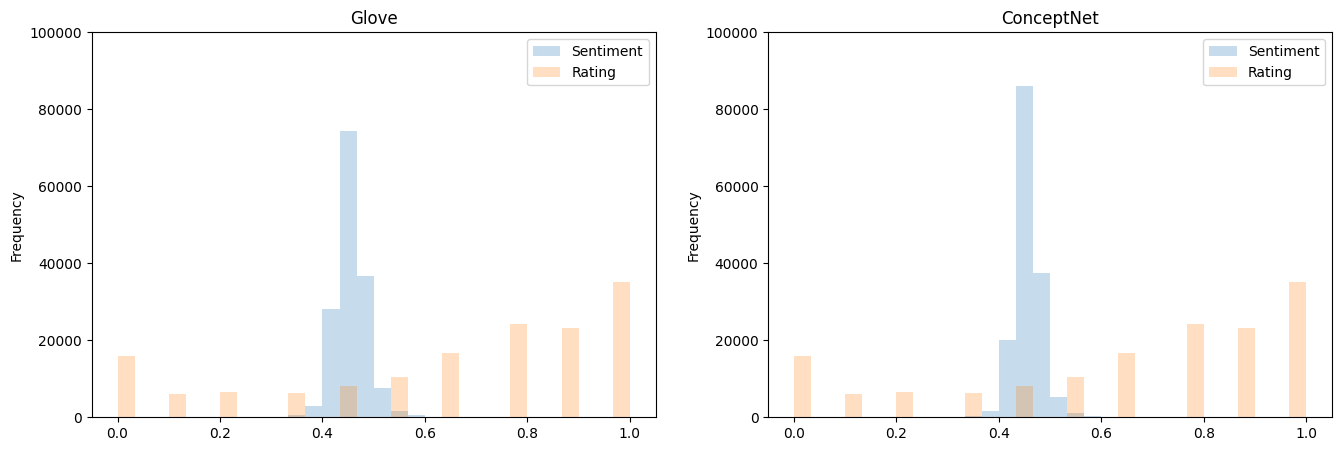

In [14]:
#snippet from our 7324 class by Dr E Larson
f = plt.figure(figsize=(16,5))

bin_num = 30
plt.subplot(1,2,1)
df_combined_glove.sentiment.plot(kind='hist', alpha=0.25, 
                        label="Sentiment",
                        bins=bin_num)

df_combined_glove.rating.plot(kind='hist', alpha=0.25, 
                        label="Rating",
                        bins=bin_num)
plt.title('Glove')
plt.legend()
plt.ylim([0, 100000])

plt.subplot(1,2,2)
df_combined_cnnb.sentiment.plot(kind='hist', alpha=0.25, 
                        label="Sentiment",
                        bins=bin_num)

df_combined_cnnb.rating.plot(kind='hist', alpha=0.25, 
                        label="Rating",
                        bins=bin_num)
plt.title('ConceptNet')
plt.legend()
plt.ylim([0, 100000])

plt.show()

The data in both Glove and ConceptNet show that overall there are higher ranked ratings regardless of the genre. But sentiment scores by the embeddings show data to be concentrated right about the median. There may be some values in the tail ends but they dont show up given the scale. 

Could this mean the choice of words in the reviews are not reflective of the rating associated with it? 

#TODO This may be too late, but what if we gave a glowing review as sentence input to glove and conceptnet what score does it give?
as a example, text_to_sentiment("The Endeavour pilot movie was fantastic, simply superb, brilliant direction, excellent actors, thrilling discoveries, rave reviews all around! Five stars!")

### Plotting the Delta columns

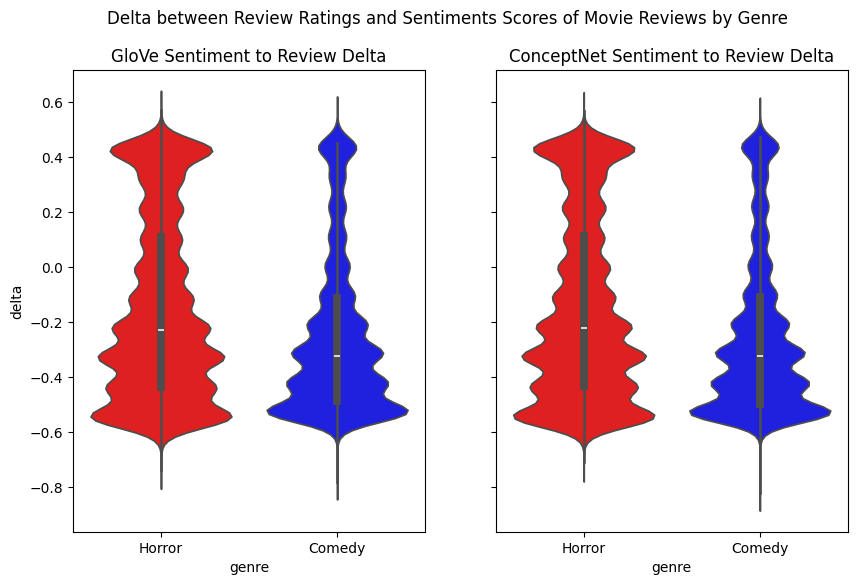

In [15]:
## Plotting the Delta columns
fig, axes = plt.subplots(1, 2, figsize=(10,6), sharey=True)
fig.suptitle('Delta between Review Ratings and Sentiments Scores of Movie Reviews by Genre')

## GloVe
# Plot the data
sns.violinplot(ax=axes[0], x='genre', y='delta', data=df_combined_glove, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[0].set_title('GloVe Sentiment to Review Delta')

## ConceptNet
# Plot the data
sns.violinplot(ax=axes[1], x='genre', y='delta', data=df_combined_cnnb, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[1].set_title('ConceptNet Sentiment to Review Delta')

plt.show()

The data above is similar for both ConceptNet and Glove. 

Overall it appears the number of positive Horror delta values are greater than  when number of instances of positive comedy delta values. This means sentiment scores tended to go higher than the corresponding ratings on some of the horror movie ratings. 

But for both horror and comedy, the bottom heavy violin plots indicate the ratings have a greater value than the sentiment score based on word analysis yielding a large number of negative delta values. A

The fact that the reviews and sentiment delta is very narrow at around the 0 and 0.2 mark indicate only few matched.

Another observation, the tail of the comedy values is long for ConeptNet, meaning the delta difference was that widespread from its true rating. The context of the review must have been lost in translation especially if there was some sarcasm involved as one might suspect for people who like comedy.

Overall sentiment analysis of reviews appears to be mismatched from the ratings. The ratings should be a good gauge for the reviews as there is generally a close correlation. But from the sentiment scores generated that is not the case. And eyeballing the data, horror scores have taken more of a hit as compared to the comedy scores.




#### Repeating the F stat on normalized data


In [16]:
#on normalized data, this may be the only f-stat data we need!

calc_stats(df_combined_glove, 'GloVe', 'sentiment', 'genre')
calc_stats(df_combined_cnnb, 'ConceptNet', 'sentiment', 'genre')


For  GloVe
--------------------
F-statistic:  18774.306421975893  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
  p value is less than alpha : Reject the null hypothesis

For  ConceptNet
--------------------
F-statistic:  15755.665718197148  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
  p value is less than alpha : Reject the null hypothesis


Based on the statistical analysis, the null hypothesis must be rejected even for scaled data. We chose 0.05 which is a typical alpha level.

Beware the perils of incorrect scaling:
As a part of the exercise of learning through the process, we discovered some anomaly in the way we handled scaling.  Our first approach, we took each individual genre_embedding dataframe and scaled it, instead of scaling the combined embedding list. ie. df_romcom_glove.. was fit_transformed and df_horror_glove was fit_transformed before being combined as the df_combined_glove set.
When we ran the f-stat on such a scaled-in-isolation dataframe, we got astronomical values for f-stat for the "normalized data" and that didnt match the pre normalization data values. This led us down a path of finding the root cause and correcting the issue. When we combined the lists and then scaled it, we got identical values for f-stat. ie combine the  two data frames for df_horror_glove and df_romcom_glove into df_combined_glove and then fit_transform that! Ditto for ConceptNet data.

Once we corrected that, as can be expected we saw identical values from pre scaled data and post.



### Comparing between Sentiment Scores for a genre
This sections seeks to combine data slightly differently, based on genre and compare how Glove and Concept Net performed.

In [17]:
#add a column for indicating the embedding used
df_horror_glove_trim['embedding'] ='GloVe'
df_horror_cnnb_trim['embedding'] = 'ConceptNet'

df_romcom_glove_trim['embedding'] ='GloVe'
df_romcom_cnnb_trim['embedding'] = 'ConceptNet'

df_combined_horror = pd.concat([df_horror_glove_trim[['rating', 'sentiment', 'embedding']], \
                                    df_horror_cnnb_trim[['rating', 'sentiment', 'embedding']]])

df_combined_comedy = pd.concat([df_romcom_glove_trim[['rating', 'sentiment', 'embedding']], \
                                    df_romcom_cnnb_trim[['rating', 'sentiment', 'embedding']]])

#scale rating
df_combined_horror['rating'] = scaler.fit_transform(df_combined_horror[['rating']])
df_combined_comedy['rating'] = scaler.fit_transform(df_combined_comedy[['rating']])

#scale sentiment
df_combined_horror['sentiment'] = scaler.fit_transform(df_combined_horror[['sentiment']])
df_combined_comedy['sentiment'] = scaler.fit_transform(df_combined_comedy[['sentiment']])

# Add a new column to each DataFrame to find the delta between sentiment and rating
df_combined_horror['delta'] = df_combined_horror['sentiment'] - df_combined_horror['rating']
df_combined_comedy['delta'] = df_combined_comedy['sentiment'] - df_combined_comedy['rating']



#### Visualizing the data

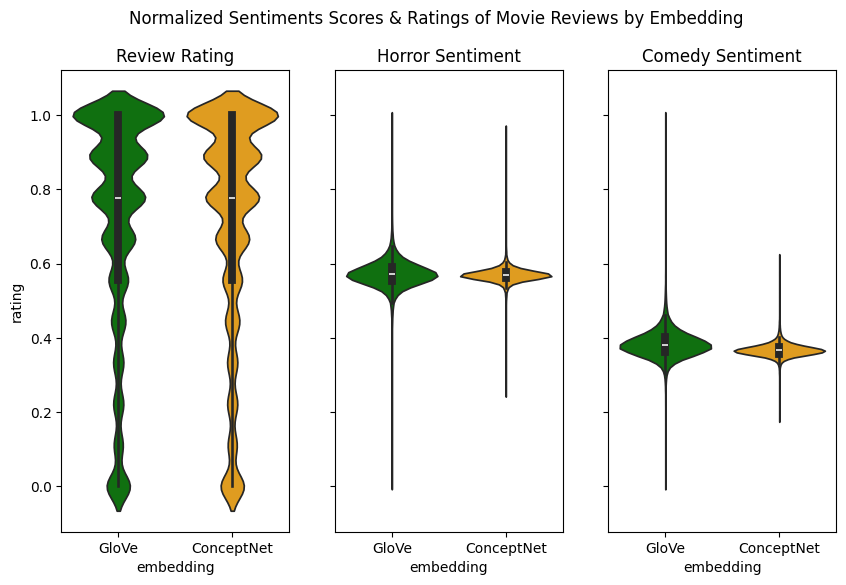

In [18]:

fig, axes = plt.subplots(1, 3, figsize=(10,6), sharey=True)
fig.suptitle('Normalized Sentiments Scores & Ratings of Movie Reviews by Embedding')

## Review Rating
# Plot the data
sns.violinplot(ax=axes[0], x='embedding', y='rating', data=df_combined_comedy, palette={'GloVe': 'green', 'ConceptNet': 'Orange'})
axes[0].set_title('Review Rating')

## Horror
# Plot the data
sns.violinplot(ax=axes[1], x='embedding', y='sentiment', data=df_combined_horror, palette={'GloVe': 'green', 'ConceptNet': 'Orange'})
axes[1].set_title('Horror Sentiment')

## Comedy
# Plot the data
sns.violinplot(ax=axes[2], x='embedding', y='sentiment', data=df_combined_comedy, palette={'GloVe': 'green', 'ConceptNet': 'Orange'})
axes[2].set_title('Comedy Sentiment')

plt.show()

#TODO Add analysis

#### Statistics on how the embedding worked on a genre
We are trying to quantify the differences that two different embedding models show when used on the same underlying data.
The null hypothesis again, is that there is no difference betweem the sentiment scores that the embeddings offer
The alternate hypothesis is that there is a difference between the scores for the two embeddings.

In [19]:

calc_stats(df_combined_horror, 'Horror', 'sentiment', 'embedding')
calc_stats(df_combined_comedy, 'Comedy', 'sentiment', 'embedding')


For  Horror
--------------------
F-statistic:  345.17506504529797  , p value: 5.7223361979243166e-77 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
  p value is less than alpha : Reject the null hypothesis

For  Comedy
--------------------
F-statistic:  11144.797617332002  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
  p value is less than alpha : Reject the null hypothesis


Again the null hypothesis must be rejected. This means that statistically, the sentiment scores on the same reviews are different between GloVe and ConceptNet.

If you look at the p-value for horror, it is very very small. 

## Conclusion

TODO: Add conclusion

The movie database had reviews and accompanying ratings. The sentiment analysis of the reviews cannot be used to gauge the ratings. However when presenting the ratings, offer reviews that have a high sentiment score, a low sentimet score, so that users can get more information. Is the sentiment score the result of a review that picked on one wrong aspect of the movie but otherwise gave it a good rating?



Identify two conferences or journals that would be interested in the results of your analysis.  

## References